### 단순하게 qtable을 dnn모델로 대체하는 경우
* 이 방시기은 frozen lake같은 경우는 큰 문제 없지만 실제로는 두가지 문제가 발생함
* Data의 iid조건 불만족(데이터간 상관관계가 매우 크고(state가 연속형인경우), 데이터 분포가 비정상임)
* replay buffer, target network트릭을 이용해서 해결해야함

In [24]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17328658243667714341
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13117161461592048719
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [25]:
def play_episodes(environ,q_net, epsilon,n_episode,opt ):   ## epsilon파트
    s = environ.reset()
    a = select_action(environ, q_net,epsilon, s, ismu = False)
    total_r = 0
    train_set = []

    for _ in range(n_episode):
        while True:
            ns, r, done, info = environ.step(a)
            train_set.append(s,a,ns,r,done)
            total_r += r
            if done:
                s = environ.reset()
                a = select_action(environ, q_net,epsilon, s, ismu = False)
                break
            else:
                s = ns
                a = select_action(environ, q_net,epsilon, s, ismu = False)

    with tf.GradientTape(watch_accessed_variables=True) as tape:         
        train_q_val = tf.concat(train_q_val,axis = 0)
        train_y = tf.concat(train_y,axis = 0)
        print(train_q_val)
        print(train_y)
        loss = tf.keras.losses.MSE(train_y, train_q_val)
    grads = tape.gradient(loss, q_net.trainable_variables)
    opt.apply_gradients(zip(grads, q_net.trainable_variables))


    mean_reward = total_r/n_episode
    return mean_reward



def select_action(environ, q_net,epsilon, state, ismu):   # sarsa -> e-greedy policy
    best_action, best_value = None, None
    
    if ismu:
        for action in range(environ.action_space.n):
            action_value = q_net(tf.convert_to_tensor([[state, action]],dtype=tf.int32))
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action 


    else:
        if np.random.choice([True, False],p = [epsilon,1-epsilon]):
            action = environ.action_space.sample()
            return action
        else:
            for action in range(environ.action_space.n):
                # q value를 그때그때 계산해서 최댓값인 a를 액션으로 선택함 --> q learing과 차이/ qlenaring은 qvalue자체를 학습함
                action_value = q_net(tf.convert_to_tensor([[state, action]],dtype=tf.int32))
                if best_value is None or best_value < action_value:
                    best_value = action_value
                    best_action = action
            return best_action 
    
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

In [26]:
%%time

# action = 0 or 1 or 2 or 3
# reward는 도착을해야만 1을 받음 나머지는 0
# state는 0~16까지
env = gym.make("FrozenLake-v1", is_slippery = True)
# env.render()
gamma = 0.9
alpha = 0.5
init_e = 1
n_epi = 50
batch_total_iter = 200

# 모델 파라미터
hidden_structure= [64, 128,64]
input_shape= 2
output_shape= 1
act_function= 'relu'
num_samples = 1

# 모델
lr_rate = 7 * 1e-3
model = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
optimizer= keras.optimizers.Adam(learning_rate=lr_rate)





##시작
e = init_e
environ, q_net, epsilon,n_episode,opt = env,model, e,n_epi,optimizer


r_cum = []
loss_cum = []

for _ in range(batch_total_iter):
    s = environ.reset()
    a = select_action(environ, q_net,epsilon, s, ismu = False)
    total_r = 0

    train_s = []
    train_a = []
    train_ns = []
    train_r = []
    train_maxq_a = []
    train_done = []
    
    for _ in range(n_episode):
        while True:
            ns, r, done, info = environ.step(a)

            train_s.append([s])
            train_a.append([a])
            train_ns.append([ns])
            train_r.append([r])
            train_done.append([done])

            best_action = select_action(environ, q_net,epsilon, s, ismu = True)
            train_maxq_a.append([best_action])

           

            total_r += r
            if done:
                break
            else:
                s = ns
                a = select_action(environ, q_net,epsilon, s, ismu = False)

    epsilon = epsilon*0.95

    train_s = tf.convert_to_tensor(train_s,dtype=tf.float32)
    train_a = tf.convert_to_tensor(train_a,dtype=tf.float32)
    train_ns = tf.convert_to_tensor(train_ns,dtype=tf.float32)
    train_r = tf.convert_to_tensor(train_r,dtype=tf.float32)
    train_maxq_a = tf.convert_to_tensor(train_maxq_a,dtype=tf.float32)
    inputs = tf.concat([train_s,train_a],axis=1)
    inputs_target = tf.concat([train_ns,train_maxq_a],axis=1)



    with tf.GradientTape(watch_accessed_variables=True) as tape:     
        q_val = q_net(inputs)
        y = (train_r + gamma*q_net(inputs_target))    
        loss = tf.keras.losses.MSE(tf.reshape(y,[1,-1]), tf.reshape(q_val,[1,-1]))
    loss_cum.append(loss)
    r_cum.append(total_r/n_episode)
    
    grads = tape.gradient(loss, q_net.trainable_variables)
    opt.apply_gradients(zip(grads, q_net.trainable_variables))
    print('성능: '+f'{total_r/n_episode}')


성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.0
성능: 0.02
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능: 0.0
성능

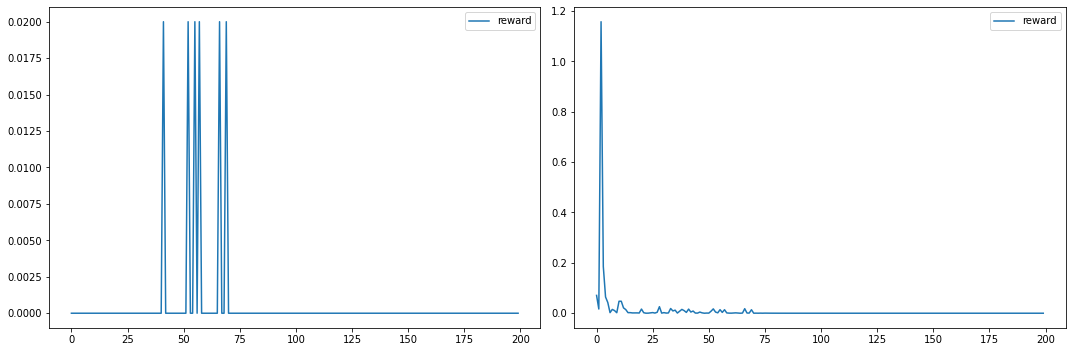

In [27]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(r_cum, label='reward')
axes[0].legend()

axes[1].plot(loss_cum, label='reward')
axes[1].legend()
fig.tight_layout()